In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ase #package called Atomic Simulation Environment which allows us to construct crystals easily
from ase.spacegroup import crystal
from ase.visualize import view 
from ase.visualize.plot import plot_atoms
from tqdm import tqdm
from ase.io import read
from ase.io import write

In [ ]:
'''

This script is designed to generate a large scale crystal meant to import into a LAMMPS script using the ASE package. 
The input involves searching up a .cif file corresponding to the unit cell structure of that particularly
desired crystal. This unit cell can be multiplied many times into a much larger supercell structure. 

@author: kmream
'''

In [11]:
# Read CIF file -> these must be downloaded and located in the same repository 
#atoms = read('1011176.cif') #quartz
#atoms = read('9011998.cif') #silicon 

atoms2 = read('quartz_unitcell.cif') 

# Replicate the unit cell
atoms2 *= (300, 250, 120)

#view(atoms2) 


In [12]:
write("quartz_supercell_emilie.lmp", atoms2, format="lammps-data", specorder=['Si', 'O'])

with open('quartz_supercell_emilie.lmp', 'w') as f:
    f.write("ID Type x y z\n")
    for i, atom in enumerate(atoms2, start=1):
        atom_type = atom.number  # or use a mapping from symbol if needed
        x, y, z = atom.position
        f.write(f"{i} {atom_type} {x:.6f} {y:.6f} {z:.6f}\n")  

In [15]:
data = pd.read_csv('quartz_supercell_emilie.txt', sep = " ")
data['ID'] = data.index + 1
data.loc[data['Type'] == 14, 'Type'] = 1
data.loc[data['Type'] == 8, 'Type'] = 2
charge_map = {1: 1.0, 2: -0.5}
data['charge'] = data['Type'].map(charge_map)
charge_col = data.pop('charge')
data.insert(2, 'charge', charge_col)

for coord in ['x', 'y', 'z']:
    center = (data[coord].max() + data[coord].min()) / 2
    data[coord] = data[coord] - center
    data[coord] = data[coord] / 10

data

,ID,Type,charge,x,y,z
0,1,2,-0.5,-42.838988,-53.047573,-32.035783
1,2,2,-0.5,-42.652243,-53.099106,-32.215939
2,3,2,-0.5,-42.700987,-52.911614,-32.396096
3,4,2,-0.5,-42.946672,-52.985402,-32.344355
4,5,2,-0.5,-43.084673,-52.849442,-32.164198
...,...,...,...,...,...,...
80999995,80999996,2,-0.5,42.659392,53.109745,32.151732
80999996,80999997,2,-0.5,42.846137,53.161277,32.331888
80999997,80999998,1,1.0,42.998437,52.797910,32.215939
80999998,80999999,1,1.0,42.652243,52.997785,32.035783


Text(0, 0.5, 'Z (nanometers)')

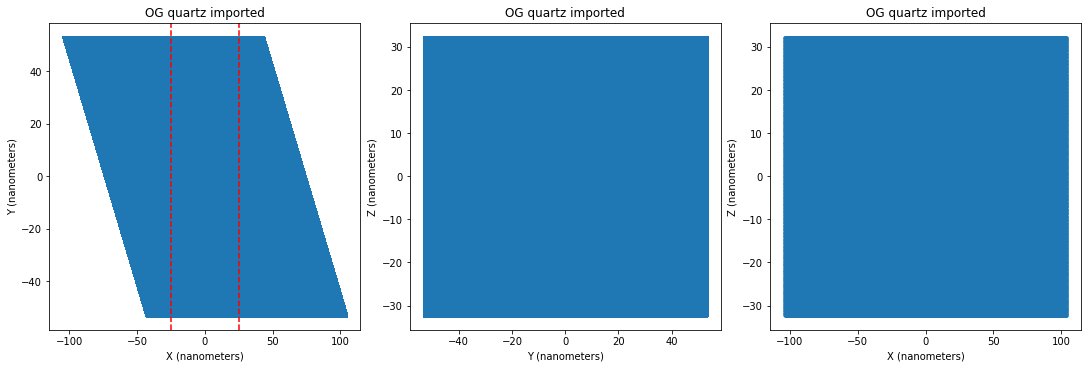

In [16]:
'''
if necessary, cut the data such that it is rectangular/perpendicular to each axes w.r.t. all 3 planes -> below code visualizes supercell crystal for verification
'''
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

axes[0].scatter(data['x'].values, data['y'].values, s = 2, marker = '.')
axes[0].axvline(x = -25, color='r', linestyle='--')
axes[0].axvline(x = 25, color='r', linestyle='--')
axes[0].set_title('OG quartz imported')
axes[0].set_xlabel('X (nanometers)')
axes[0].set_ylabel('Y (nanometers)')

axes[1].scatter(data['y'].values, data['z'].values, s = 2, marker = '.')
axes[1].set_title('OG quartz imported')
axes[1].set_xlabel('Y (nanometers)')
axes[1].set_ylabel('Z (nanometers)')

axes[2].scatter(data['x'].values, data['z'].values, s = 2, marker = '.')
axes[2].set_title('OG quartz imported')
axes[2].set_xlabel('X (nanometers)')
axes[2].set_ylabel('Z (nanometers)')

In [17]:
xcut_low, xcut_high, ycut_low, ycut_high, zcut_low, zcut_high = -25, 25, -50, 50, -25, 25
def cutoff(data):
    data_new = data[(data['x'] < xcut_high)]
    data_new = data_new[(data['x'] > xcut_low)]
    data_new = data_new[data_new['y'] > ycut_low]
    data_new = data_new[data_new['y'] < ycut_high]
    data_new = data_new[data_new['z'] > zcut_low]
    data_new = data_new[data_new['z'] < zcut_high]
    return data_new

data = cutoff(data)
for coord in ['x', 'y', 'z']:
    center = (data[coord].max() + data[coord].min()) / 2
    data[coord] = data[coord] - center

len(data)

/var/folders/8_/7cxg7b591zn267gy4zwgyw6h0000gn/T/ipykernel_2660/2513552147.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_new = data_new[(data['x'] > xcut_low)]


19910422

Text(0, 0.5, 'Z (nanometers)')

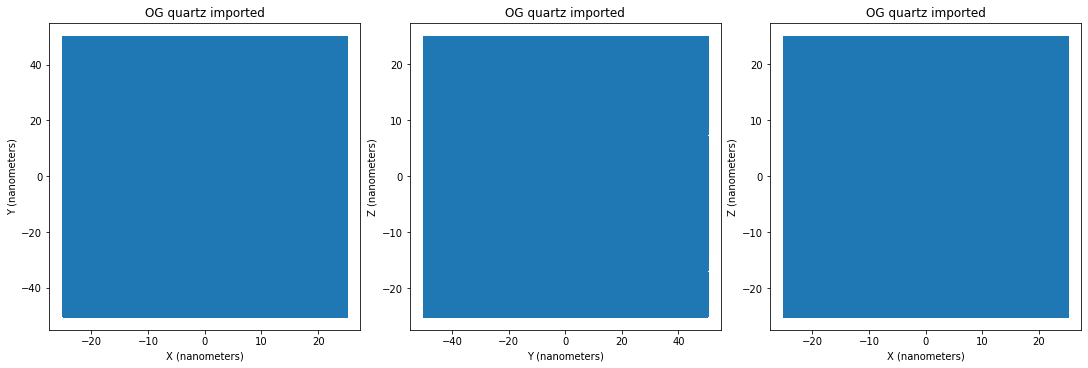

In [18]:
'''
if necessary, cut the data such that it is rectangular/perpendicular to each axes w.r.t. all 3 planes -> below code visualizes supercell crystal for verification
'''
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

axes[0].scatter(data['x'].values, data['y'].values, s = 2, marker = '.')
axes[0].set_title('OG quartz imported')
axes[0].set_xlabel('X (nanometers)')
axes[0].set_ylabel('Y (nanometers)')

axes[1].scatter(data['y'].values, data['z'].values, s = 2, marker = '.')
axes[1].set_title('OG quartz imported')
axes[1].set_xlabel('Y (nanometers)')
axes[1].set_ylabel('Z (nanometers)')

axes[2].scatter(data['x'].values, data['z'].values, s = 2, marker = '.')
axes[2].set_title('OG quartz imported')
axes[2].set_xlabel('X (nanometers)')
axes[2].set_ylabel('Z (nanometers)')

In [19]:
def write_lammps_data(df, filename):
    with open(filename, 'w') as f:
        f.write("#LAMMPS data file via pandas\n\n")
        f.write(f"{len(df)} atoms\n")
        f.write(f"{df['Type'].nunique() + 1} atom types\n\n")

        # Assuming orthogonal box and bounds can be inferred from coordinates
        xlo, xhi = df['x'].min(), df['x'].max()
        ylo, yhi = df['y'].min(), df['y'].max()
        zlo, zhi = df['z'].min(), df['z'].max()

        # Add some padding on each wall
        pad = 3.0
        f.write(f"{xlo - pad:.6f} {xhi + pad:.6f} xlo xhi\n")
        #f.write(f"{ylo - pad:.6f} {yhi + pad:.6f} ylo yhi\n")
        f.write(f"-400 400 ylo yhi\n") #modify the direction which you're shooting the gold ion to be much longer 
        f.write(f"{zlo - pad:.6f} {zhi + pad:.6f} zlo zhi\n\n")
        
        f.write("Masses\n\n")
        f.write(f" 1 28.08500000 # Si\n")
        f.write(f" 2 15.99900000 # O\n")
        f.write(f" 3 196.9665500 # Au\n\n")

        f.write("Atoms\n\n")
        for _, row in df.iterrows():
            f.write(f"{int(row['ID'])} {int(row['Type'])} {int(row['charge'])} {row['x']} {row['y']} {row['z']}\n")

In [20]:
write_lammps_data(data, 'quartz_supercell_emilie.lmp')